# RPPG and HRV Feature Evaluation

As part of this project, I'll doing RPPG on the Sample Video data first and then doing the feature extraction before considering to applying this into real-time implementation.

### Hypothesis

Since the point in the HRV is the RR-Interval analysis. The key point is to measure the distance-time for each true peak heart beat signal. Let's see in the action.

The peak in the graph, is suppposed to be the heart beat.

Based on some hypotesis:
1. Physiological Range: The RR intervals should typically be within the range of 300 ms (0.3 s) to 1300 ms (1.3 s). This range corresponds to heart rates between approximately 46 bpm and 200 bpm, which covers most normal physiological conditions.
2. Removal of Erroneous Peaks: Intervals shorter than 300 ms may indicate erroneous detections, such as additional peaks that do not correspond to actual heartbeats. These should be filtered out to maintain data integrity1.

### Constraint

Typical HRV analysis takes the samples to be around 2 minute length sample as the minimum so we can doing the HRV analysis.

Based on the device, it maybe takes around 2 - 5 minutes to process a 2 minute signal, before considering any optimization.

### Plan

The game plan is to make an HUD showing the physiology data such as heart and the HRV calculation as probably similar with this

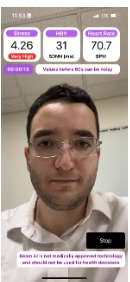

On the other side, so when the program is run, there's some pipeline program to handle many programs such as
- RPPG (Probably we have 4 instance of this for sliding window accross 30 seconds interval)
- Temporal Stress (Using Baevsky Stress Index - Using the RR we can estimate the stress level for the first 2 minutes)
- Facial Emotion (Using the same Mediapipe Face Landmark, we can also doing other pipelines to predict the emotion, but this is optional since we have to optimize the first and second).


In [30]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy


### Notes:
As part of make the Sampling rate uniform, let's set the sampling rate around 35 Hz. Since the Ground truth dataset has 64 Hz record sampling rate, the Downsampling is required.

**Samples uses the Task-1 (Rest Task)**

In [31]:
## Original Video
original_video = cv2.VideoCapture('../Samples/Original/vid_s53_T3.avi') # 35 Hz

## Ground Truth
ground_truth = pd.read_csv('../Samples/Original/bvp_s53_T3.csv', header=None).values.flatten() # 64 Hz

In [32]:
## Downsampling the ground truth to match on 35.14 Hz

# Original ground truth sampling rate
original_fs = 64.0  # Hz

# Target sampling rate
target_fs = 35  # Hz

# Calculate the number of samples after resampling
num_samples = int(len(ground_truth) * (target_fs / original_fs))

# Resample the ground truth data
downsampled_ground_truth = scipy.signal.resample(ground_truth, num_samples)

## Show the downsampled ground truth length
print(f"Original ground truth length: {len(ground_truth)}")
print(f"Downsampled ground truth length: {len(downsampled_ground_truth)}")


Original ground truth length: 11520
Downsampled ground truth length: 6300


<hr style="border:20px solid aqua; border-radius:5px">

### Consecutive Function for Preprocessing the Signal.

As pre-processing pipeline require you to setup some steps before working with the signal data. But there's the task that are going to do.
1. Preprocessing pipeline
2. RR Interval Calculation
3. Artificial Detection and Correction

In [33]:
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H

In [34]:
def preprocess_ppg(signal, fs = 35):
    """ Computes the Preprocessed PPG Signal, this steps include the following:
        1. Moving Average Smoothing
        2. Bandpass Filtering
        3. Normalization
        
        Parameters:
        ----------
        signal (numpy array): 
            The PPG Signal to be preprocessed
        fs (float): 
            The Sampling Frequency of the Signal
            
        Returns:
        --------
        numpy array: 
            The Preprocessed PPG Signal
    
    """ 

    ## Moving Average Smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed_signal = np.convolve(signal, np.ones(window)/window, mode='same')

    b, a = scipy.signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b, a, smoothed_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = scipy.signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = scipy.signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    filtered_signal = np.convolve(filtered, np.ones(window)/window, mode='same')

    # Normalize using Standard Deviation
    normalized_signal = (filtered_signal - filtered_signal.mean()) / filtered_signal.std()

    return normalized_signal


In [35]:
def get_rr_interval(signal, fs = 35):
    """Computes the distance between each peak in the signal

    Parameters:
    ----------
    signal (numpy array): 
        The PPG Signal to be preprocessed
    fs (float):
        The Sampling Frequency of the Signal
    
    Returns:
    --------
    numpy array: 
        The RR Interval Signal
    
    Notes:
    ------
    Since the signal is already being preprocessed and normalize around 0 and 1, 
    It suppose have the maximum amplitude peak at 1. 
    .
    Using the adaptive thresholding method to detect the peaks in the signal
    should potentially give a better result with different threshold on the moving window.

    """

    ## Adaptive thresholding
    window_size = fs * 2  # 2-second window
    rolling_mean = np.convolve(signal,
                              np.ones(window_size)/window_size, 
                              mode='same')
    adaptive_threshold = rolling_mean + 0.5 * np.std(signal)

    peaks, properties = scipy.signal.find_peaks(signal,
                                               distance=fs * 0.5, # 0.5-second distance between peaks   
                                               prominence=0.1,  # Consider peak prominence
                                               height=adaptive_threshold)
    ## Convert into time
    rr_interval = np.diff(peaks) / fs # * 1000.0 - in milliseconds

    return rr_interval

In [36]:
def clean_rr_interval(rr_interval):
    """Clean the RR Interval Signal by removing the outliers

    Parameters:
    ----------
    rr_interval (numpy array): 
        The RR Interval Signal to be cleaned
    
    Returns:
    --------
    numpy array: 
        The Cleaned RR Interval Signal
    
    Notes:
    ------
    The RR Interval Signal is cleaned by removing the outliers, 
    A typical physiological limit for an RR interval is considered to be between 0.6 and 1.2 seconds (or 600-1200 milliseconds),
    which translates to a normal resting heart rate range of roughly 60-100 beats per minute; 

    But since take noise into the account, let's add the lower limit to 0.4 seconds (400 milliseconds) 
    and upper limit to 1.5 seconds (1500 milliseconds)

    """

    ## Remove physical impossible values
    # Convert to milliseconds
    rr_ms = rr_interval
    	
    # Physiological limits (typically 600-1200 ms)
    valid_rr = rr_ms[(rr_ms >= 0.6) & (rr_ms <= 1.2)]
    
    # Check for dramatic changes
    rr_diff = np.abs(np.diff(valid_rr))
    valid_rr = valid_rr[np.where(rr_diff < 0.2 * valid_rr[:-1])[0]]

    return valid_rr

In [37]:
def clean_rr_adaptive(rr_intervals, quality_metric=None):
    """
    Adaptive RR interval cleaning based on signal quality
    """
    # Initial basic range (conservative)
    MIN_RR = 0.6  # 100 BPM
    MAX_RR = 1.2  # 50 BPM
    
    # Step 1: Remove extreme outliers
    valid_rr = rr_intervals[(rr_intervals >= MIN_RR) & (rr_intervals <= MAX_RR)]
    
    if len(valid_rr) < 3:
        return valid_rr
        
    # Step 2: Statistical validation
    mean_rr = np.mean(valid_rr)
    std_rr = np.std(valid_rr)
    
    # Adjust thresholds based on signal quality
    if quality_metric is None:
        # Use coefficient of variation as quality metric
        quality_metric = std_rr / mean_rr
    
    # Adaptive thresholds
    threshold_multiplier = 1.0 + quality_metric
    valid_range = threshold_multiplier * std_rr
    
    # Step 3: Remove statistical outliers
    valid_rr = valid_rr[np.abs(valid_rr - mean_rr) <= valid_range]
    
    # Step 4: Check sequential differences
    if len(valid_rr) >= 2:
        diff_threshold = 0.3 * mean_rr  # Allow 30% change
        rr_diff = np.abs(np.diff(valid_rr))
        valid_indices = np.where(rr_diff < diff_threshold)[0]
        valid_rr = valid_rr[valid_indices]
    
    return valid_rr

<hr style="border:20px solid green; border-radius:5px">

### Implementation
As for the demo, this will try to obtain the 2 minute length of signal with RPPG and check for feature extraction as well comparing to the Ground truth signal.

**For this purpose, we will use the Task 1 since it was consistent task and have little noise**.


### Setup Mediapipe Cheeks ROI.

Setup the functions and properties for doing the RPPGs

In [38]:
## Create Facelandmarker Object
base_options = python.BaseOptions(model_asset_path="Models/face_landmarker.task")
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    num_faces=1,
    running_mode = VisionRunningMode.VIDEO,
)
detector = vision.FaceLandmarker.create_from_options(options)

In [39]:
def get_cheek_rois(landmarks, image_shape):
    h, w, _ = image_shape
    left_cheek_indices = [111, 121, 50, 142]
    right_cheek_indices = [350, 340, 355, 280]

    left_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in left_cheek_indices]
    right_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in right_cheek_indices]

    left_cheek_rect = (
        min([pt[0] for pt in left_cheek_points]), min([pt[1] for pt in left_cheek_points]),
        max([pt[0] for pt in left_cheek_points]), max([pt[1] for pt in left_cheek_points])
    )
    # print("Left Cheek Rect:", left_cheek_rect)
    right_cheek_rect = (
        min([pt[0] for pt in right_cheek_points]), min([pt[1] for pt in right_cheek_points]),
        max([pt[0] for pt in right_cheek_points]), max([pt[1] for pt in right_cheek_points])
    )
    # print("Right Cheek Rect:", right_cheek_rect)

    return left_cheek_rect, right_cheek_rect


In [40]:
def extract_rgb_from_rect(rect, image):
    x_min, y_min, x_max, y_max = rect
    roi = image[y_min:y_max, x_min:x_max]
    return roi

<hr style="border:20px solid red; border-radius:5px">

## Moving Window
Well, 4 instance list for moving avg

In [41]:
# Initialize lists for RGB values for each window
window_0_r = []  # R values for window starting at 0:00
window_0_g = []  # G values
window_0_b = []  # B values
window_0_combined = []  # Combined RGB values   

window_1_r = []  # R values for window starting at 0:30
window_1_g = []
window_1_b = []
window_1_combined = []

window_2_r = []  # R values for window starting at 1:00
window_2_g = []
window_2_b = []
window_2_combined = []

window_3_r = []  # R values for window starting at 1:30
window_3_g = []
window_3_b = []
window_3_combined = []


### Implementation

Setup some properties and doing the loop for the 2 minute frame to collect the RGB signal value.

In [42]:
""" RGB Signal Variables

    Variables to store the RGB signals from the left and right cheeks,
    as well as the combined signal from both cheeks.

"""
# Lists to store RGB values
left_r_signal, left_g_signal, left_b_signal = [], [], []
right_r_signal, right_g_signal, right_b_signal = [], [], []

# Lists to store combined RGB values
combined_r_signal, combined_g_signal, combined_b_signal = [], [], []

# Utils Properties
fs = 35 
interval_duration = 120 # 120 seconds interval
frame_index = 0
WINDOW_SIZE = fs * 120  # 2 minutes worth of frames

buffer_size = int(fs * interval_duration) # 35 Hz * 120 seconds = 4200 frames
frame_buffer = []

In [43]:
# """ Main Loop """ 
# try:
#     f_count = 0
#     f_total = int(original_video.get(cv2.CAP_PROP_FRAME_COUNT))

#     while original_video.isOpened():
#         print(f'Processing Frame {f_count}/{f_total}', end='\r')
#         ret, frame = original_video.read()

#         current_time = f_count / fs  # Time in seconds
        
#         if not ret:
#             break
        
#         ### 3. Mendeteksi area wajah menggunakan mediapipe
#         h, w, _ = frame.shape
        
#         ### 3.1 Mengkonversi frame ke RGB
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
#         mp_image = mp.Image(
#             image_format=mp.ImageFormat.SRGB,
#             data=frame_rgb
#         )
#         ### 3.2 Memproses frame menggunakan face_detection
#         frame_timestamp_ms = int((frame_index / fs) * 1000)

#         result = detector.detect_for_video(mp_image, frame_timestamp_ms)

#         if result.face_landmarks:
#             for face_landmark in result.face_landmarks:
#                 # Get cheek ROIs
#                 left_cheek_rect, right_cheek_rect = get_cheek_rois(face_landmark, frame.shape)

#                 # Draw both cheek ROIs with rectangles
#                 cv2.rectangle(frame, (left_cheek_rect[0], left_cheek_rect[1]), (left_cheek_rect[2], left_cheek_rect[3]), (0, 255, 0), 2)
#                 cv2.rectangle(frame, (right_cheek_rect[0], right_cheek_rect[1]), (right_cheek_rect[2], right_cheek_rect[3]), (0, 255, 0), 2)

#                 # Extract the left and right cheek ROIs
#                 left_cheek_roi = extract_rgb_from_rect(left_cheek_rect, frame)
#                 right_cheek_roi = extract_rgb_from_rect(right_cheek_rect, frame)

#                 # Calculate mean pixel values for the RGB channels
#                 left_cheek_rgb = cv2.mean(left_cheek_roi)[:3]
#                 right_cheek_rgb = cv2.mean(right_cheek_roi)[:3]

#                 # Append the RGB values to the respective lists
#                 left_r_signal.append(left_cheek_rgb[0])
#                 left_g_signal.append(left_cheek_rgb[1])
#                 left_b_signal.append(left_cheek_rgb[2])

#                 right_r_signal.append(right_cheek_rgb[0])
#                 right_g_signal.append(right_cheek_rgb[1])
#                 right_b_signal.append(right_cheek_rgb[2])

#                 # Combine and average the RGB values from both cheeks
#                 combined_r = (left_cheek_rgb[0] + right_cheek_rgb[0]) / 2
#                 combined_g = (left_cheek_rgb[1] + right_cheek_rgb[1]) / 2
#                 combined_b = (left_cheek_rgb[2] + right_cheek_rgb[2]) / 2

#                 # Append the combined RGB values to the respective lists
#                 combined_r_signal.append(combined_r)
#                 combined_g_signal.append(combined_g)
#                 combined_b_signal.append(combined_b)

#                 # Window 0 (starts at 0:00)
#                 if current_time >= 0:
#                     window_0_r.append(combined_r)
#                     window_0_g.append(combined_g)
#                     window_0_b.append(combined_b)
#                     if len(window_0_r) >= WINDOW_SIZE:
#                         # Reset windows
#                         window_0_combined = np.array([window_0_r, window_0_g, window_0_b])
#                         window_0_combined = window_0_combined.reshape(1, 3, -1)
#                         window_0_combined = POS(window_0_combined, fps=35)
#                         window_0_combined = window_0_combined.reshape(-1)

#                         window_0_r = []
#                         window_0_g = []
#                         window_0_b = []

#                         print(f"Window 0 processed at {current_time}s")
                
#                 # Window 1 (starts at 0:30)
#                 if current_time >= 30:
#                     window_1_r.append(combined_r)
#                     window_1_g.append(combined_g)
#                     window_1_b.append(combined_b)
#                     if len(window_1_r) >= WINDOW_SIZE:
#                         window_1_combined = np.array([window_1_r, window_1_g, window_1_b])
#                         window_1_combined = window_1_combined.reshape(1, 3, -1)
#                         window_1_combined = POS(window_1_combined, fps=35)
#                         window_1_combined = window_1_combined.reshape(-1)
                        
#                         window_1_r = []
#                         window_1_g = []
#                         window_1_b = []
#                         print(f"Window 1 processed at {current_time}s")
                
#                 # Window 2 (starts at 1:00)
#                 if current_time >= 60:
#                     window_2_r.append(combined_r)
#                     window_2_g.append(combined_g)
#                     window_2_b.append(combined_b)
#                     if len(window_2_r) >= WINDOW_SIZE:
#                         window_2_combined = np.array([window_2_r, window_2_g, window_2_b])
#                         window_2_combined = window_2_combined.reshape(1, 3, -1)
#                         window_2_combined = POS(window_2_combined, fps=35)
#                         window_2_combined = window_2_combined.reshape(-1)
                        
#                         window_2_r = []
#                         window_2_g = []
#                         window_2_b = []
#                         print(f"Window 2 processed at {current_time}s")
                
#                 # Window 3 (starts at 1:30)
#                 if current_time >= 90:
#                     window_3_r.append(combined_r)
#                     window_3_g.append(combined_g)
#                     window_3_b.append(combined_b)
#                     if len(window_3_r) >= WINDOW_SIZE:
#                         window_3_combined = np.array([window_3_r, window_3_g, window_3_b])
#                         window_3_combined = window_3_combined.reshape(1, 3, -1)
#                         window_3_combined = POS(window_3_combined, fps=35)
#                         window_3_combined = window_3_combined.reshape(-1)

#                         window_3_r = []
#                         window_3_g = []
#                         window_3_b = []
#                         print(f"Window 3 processed at {current_time}s")

#                 # # Extract the mean RGB values from the left and right cheek ROIs        
#                 # left_cheek_rgb = extract_rgb_from_rect(left_cheek_rect, frame)
#                 # right_cheek_rgb = extract_rgb_from_rect(right_cheek_rect, frame)

#                 # # Append the RGB values to the respective lists
#                 # left_r_signal.append(np.mean(left_cheek_rgb[0]))
#                 # left_g_signal.append(np.mean(left_cheek_rgb[1]))
#                 # left_b_signal.append(np.mean(left_cheek_rgb[2]))

#                 # right_r_signal.append(np.mean(right_cheek_rgb[0]))
#                 # right_g_signal.append(np.mean(right_cheek_rgb[1]))
#                 # right_b_signal.append(np.mean(right_cheek_rgb[2]))

#         # if results.detections: # If there are faces detected
#         #     for detection in results.detections: # Loop through all the detected faces
#         #         ### 3.3 Mendapatkan bounding box dari wajah
#         #         bbox = detection.location_data.relative_bounding_box
#         #         ### 3.4 Mendapatkan lebar dan tinggi frame
#         #         h, w, _ = frame.shape
#         #         ### 3.5 Mengkonversi bounding box ke koordinat piksel
#         #         x, y = int(bbox.xmin * w), int(bbox.ymin * h)
#         #         ### 3.6 Mengkonversi lebar dan tinggi bounding box ke koordinat piksel
#         #         width, height = int(bbox.width * w), int(bbox.height * h)
                
#         #         ### 3.8 Menggambar bounding box pada frame
                
#         #         ### 4 Mendapatkan nilai rata-rata piksel dari ROI dan menambahkannya ke signal
#         #         # Define forehead ROI
#         #         forehead_x = x + width // 4  # Start slightly to the right of the left edge
#         #         forehead_y = y // 2 + 55 # Start at the top of the bounding box
#         #         forehead_width = width // 2  # Half the width of the bounding box
#         #         forehead_height = height // 5  # Quarter the height of the bounding box
                
#         #         # Extract the forehead ROI
#         #         roi = frame[forehead_y:forehead_y+forehead_height, forehead_x:forehead_x+forehead_width]
                
#         #         # Optional: Draw the forehead ROI on the frame for visualization
#         #         cv2.rectangle(frame, 
#         #                       (forehead_x, forehead_y), 
#         #                       (forehead_x + forehead_width, forehead_y + forehead_height), 
#         #                       (0, 255, 0), 2)

#         #         # Calculate mean pixel values for the RGB channels
#         #         r_signal.append(np.mean(roi[:, :, 0]))
#         #         g_signal.append(np.mean(roi[:, :, 1]))
#         #         b_signal.append(np.mean(roi[:, :, 2]))

#         # annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), result)

#         # Add frame to buffer
#         frame_buffer.append(frame)
#         f_count += 1
#         frame_index += 1

#         ## Convert back to BGR
#         cv2.imshow('frame', frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     original_video.release()
#     cv2.destroyAllWindows()
    
# except Exception as e:
#     original_video.release()
#     cv2.destroyAllWindows()
#     print(f"An error occurred: {e}")

In [44]:
""" Main Loop """ 
try:
    f_count = 0
    f_total = int(original_video.get(cv2.CAP_PROP_FRAME_COUNT))

    while original_video.isOpened():
        print(f'Processing Frame {f_count}/{f_total}', end='\r')
        ret, frame = original_video.read()

        current_time = f_count / fs  # Time in seconds
        
        if not ret:
            break
        
        ### 3. Mendeteksi area wajah menggunakan mediapipe
        h, w, _ = frame.shape
        
        ### 3.1 Mengkonversi frame ke RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=frame_rgb
        )
        ### 3.2 Memproses frame menggunakan face_detection
        frame_timestamp_ms = int((frame_index / fs) * 1000)

        result = detector.detect_for_video(mp_image, frame_timestamp_ms)

        if result.face_landmarks:
            for face_landmark in result.face_landmarks:
                # Get cheek ROIs
                left_cheek_rect, right_cheek_rect = get_cheek_rois(face_landmark, frame.shape)

                # Draw both cheek ROIs with rectangles
                cv2.rectangle(frame, (left_cheek_rect[0], left_cheek_rect[1]), (left_cheek_rect[2], left_cheek_rect[3]), (0, 255, 0), 2)
                cv2.rectangle(frame, (right_cheek_rect[0], right_cheek_rect[1]), (right_cheek_rect[2], right_cheek_rect[3]), (0, 255, 0), 2)

                # Extract the left and right cheek ROIs
                left_cheek_roi = extract_rgb_from_rect(left_cheek_rect, frame)
                right_cheek_roi = extract_rgb_from_rect(right_cheek_rect, frame)

                # Calculate mean pixel values for the RGB channels
                left_cheek_rgb = cv2.mean(left_cheek_roi)[:3]
                right_cheek_rgb = cv2.mean(right_cheek_roi)[:3]

                # # Append the RGB values to the respective lists
                # left_r_signal.append(left_cheek_rgb[0])
                # left_g_signal.append(left_cheek_rgb[1])
                # left_b_signal.append(left_cheek_rgb[2])

                # right_r_signal.append(right_cheek_rgb[0])
                # right_g_signal.append(right_cheek_rgb[1])
                # right_b_signal.append(right_cheek_rgb[2])

                # Combine and average the RGB values from both cheeks
                combined_r = (left_cheek_rgb[0] + right_cheek_rgb[0]) / 2
                combined_g = (left_cheek_rgb[1] + right_cheek_rgb[1]) / 2
                combined_b = (left_cheek_rgb[2] + right_cheek_rgb[2]) / 2

                # Append the combined RGB values to the respective lists
                combined_r_signal.append(combined_r)
                combined_g_signal.append(combined_g)
                combined_b_signal.append(combined_b)

                # Window 0 (starts at 0:00)
                if current_time >= 0:
                    
                    window_0_r.append(combined_r)
                    window_0_g.append(combined_g)
                    window_0_b.append(combined_b)
                    if len(window_0_r) >= WINDOW_SIZE:
                        # Reset windows
                        window_0_combined = np.array([window_0_r, window_0_g, window_0_b])
                        window_0_combined = window_0_combined.reshape(1, 3, -1)
                        window_0_combined = POS(window_0_combined, fps=35)
                        window_0_combined = window_0_combined.reshape(-1)

                        window_0_r = []
                        window_0_g = []
                        window_0_b = []

                        print(f"Window 0 processed at {current_time}s")
                
                # Window 1 (starts at 0:30)
                if current_time >= 30:
                    window_1_r.append(combined_r)
                    window_1_g.append(combined_g)
                    window_1_b.append(combined_b)
                    if len(window_1_r) >= WINDOW_SIZE:
                        window_1_combined = np.array([window_1_r, window_1_g, window_1_b])
                        window_1_combined = window_1_combined.reshape(1, 3, -1)
                        window_1_combined = POS(window_1_combined, fps=35)
                        window_1_combined = window_1_combined.reshape(-1)
                        
                        window_1_r = []
                        window_1_g = []
                        window_1_b = []
                        print(f"Window 1 processed at {current_time}s")
                
                # Window 2 (starts at 1:00)
                if current_time >= 60:
                    window_2_r.append(combined_r)
                    window_2_g.append(combined_g)
                    window_2_b.append(combined_b)
                    if len(window_2_r) >= WINDOW_SIZE:
                        window_2_combined = np.array([window_2_r, window_2_g, window_2_b])
                        window_2_combined = window_2_combined.reshape(1, 3, -1)
                        window_2_combined = POS(window_2_combined, fps=35)
                        window_2_combined = window_2_combined.reshape(-1)
                        
                        window_2_r = []
                        window_2_g = []
                        window_2_b = []
                        print(f"Window 2 processed at {current_time}s")
                
                # Window 3 (starts at 1:30)
                if current_time >= 90:
                    window_3_r.append(combined_r)
                    window_3_g.append(combined_g)
                    window_3_b.append(combined_b)
                    if len(window_3_r) >= WINDOW_SIZE:
                        window_3_combined = np.array([window_3_r, window_3_g, window_3_b])
                        window_3_combined = window_3_combined.reshape(1, 3, -1)
                        window_3_combined = POS(window_3_combined, fps=35)
                        window_3_combined = window_3_combined.reshape(-1)

                        window_3_r = []
                        window_3_g = []
                        window_3_b = []
                        print(f"Window 3 processed at {current_time}s")

                # # Extract the mean RGB values from the left and right cheek ROIs        
                # left_cheek_rgb = extract_rgb_from_rect(left_cheek_rect, frame)
                # right_cheek_rgb = extract_rgb_from_rect(right_cheek_rect, frame)

                # # Append the RGB values to the respective lists
                # left_r_signal.append(np.mean(left_cheek_rgb[0]))
                # left_g_signal.append(np.mean(left_cheek_rgb[1]))
                # left_b_signal.append(np.mean(left_cheek_rgb[2]))

                # right_r_signal.append(np.mean(right_cheek_rgb[0]))
                # right_g_signal.append(np.mean(right_cheek_rgb[1]))
                # right_b_signal.append(np.mean(right_cheek_rgb[2]))

        # if results.detections: # If there are faces detected
        #     for detection in results.detections: # Loop through all the detected faces
        #         ### 3.3 Mendapatkan bounding box dari wajah
        #         bbox = detection.location_data.relative_bounding_box
        #         ### 3.4 Mendapatkan lebar dan tinggi frame
        #         h, w, _ = frame.shape
        #         ### 3.5 Mengkonversi bounding box ke koordinat piksel
        #         x, y = int(bbox.xmin * w), int(bbox.ymin * h)
        #         ### 3.6 Mengkonversi lebar dan tinggi bounding box ke koordinat piksel
        #         width, height = int(bbox.width * w), int(bbox.height * h)
                
        #         ### 3.8 Menggambar bounding box pada frame
                
        #         ### 4 Mendapatkan nilai rata-rata piksel dari ROI dan menambahkannya ke signal
        #         # Define forehead ROI
        #         forehead_x = x + width // 4  # Start slightly to the right of the left edge
        #         forehead_y = y // 2 + 55 # Start at the top of the bounding box
        #         forehead_width = width // 2  # Half the width of the bounding box
        #         forehead_height = height // 5  # Quarter the height of the bounding box
                
        #         # Extract the forehead ROI
        #         roi = frame[forehead_y:forehead_y+forehead_height, forehead_x:forehead_x+forehead_width]
                
        #         # Optional: Draw the forehead ROI on the frame for visualization
        #         cv2.rectangle(frame, 
        #                       (forehead_x, forehead_y), 
        #                       (forehead_x + forehead_width, forehead_y + forehead_height), 
        #                       (0, 255, 0), 2)

        #         # Calculate mean pixel values for the RGB channels
        #         r_signal.append(np.mean(roi[:, :, 0]))
        #         g_signal.append(np.mean(roi[:, :, 1]))
        #         b_signal.append(np.mean(roi[:, :, 2]))

        # annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), result)

        # Add frame to buffer
        frame_buffer.append(frame)
        f_count += 1
        frame_index += 1

        ## Convert back to BGR
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    original_video.release()
    cv2.destroyAllWindows()
    
except Exception as e:
    original_video.release()
    cv2.destroyAllWindows()
    print(f"An error occurred: {e}")

Window 0 processed at 119.97142857142858s
Window 1 processed at 149.97142857142856s
Window 2 processed at 179.97142857142856s


## Display the Moving Window
Well, 4 instance list for moving avg

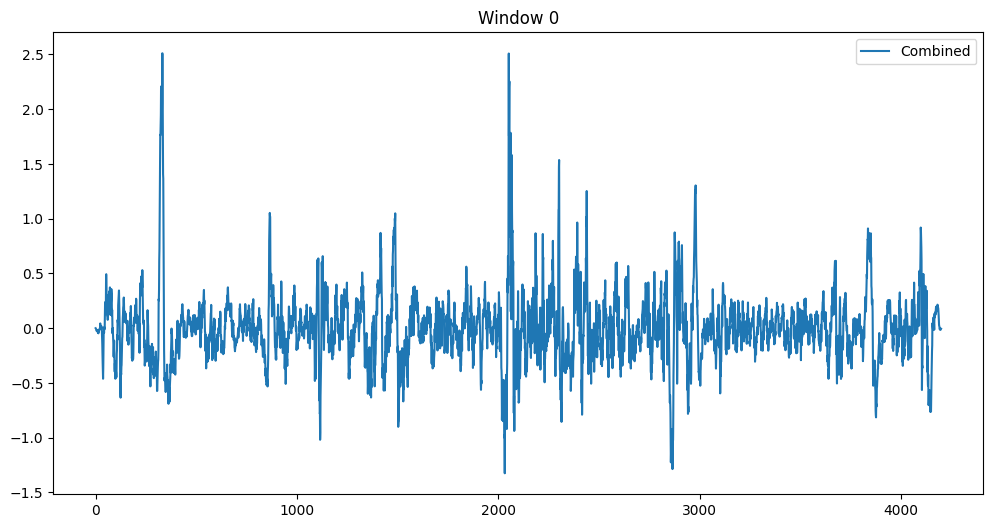

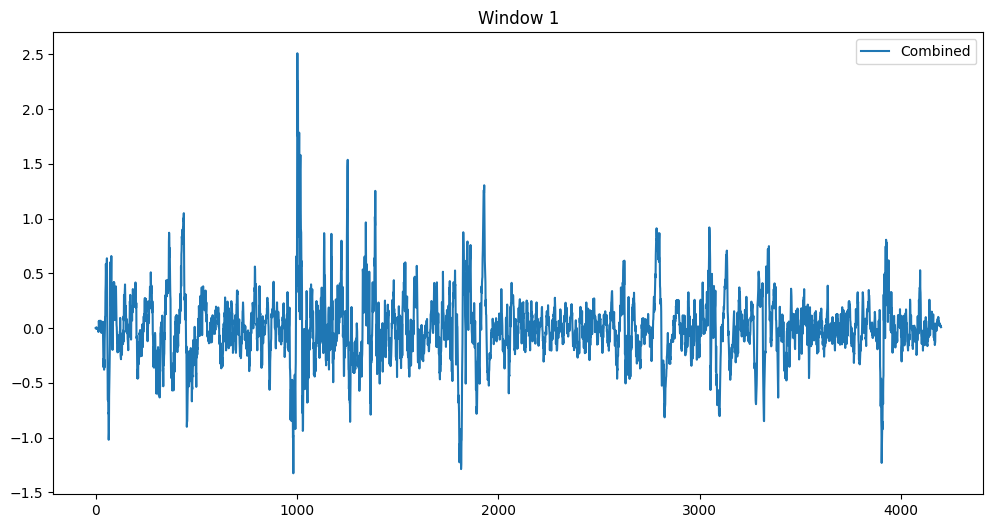

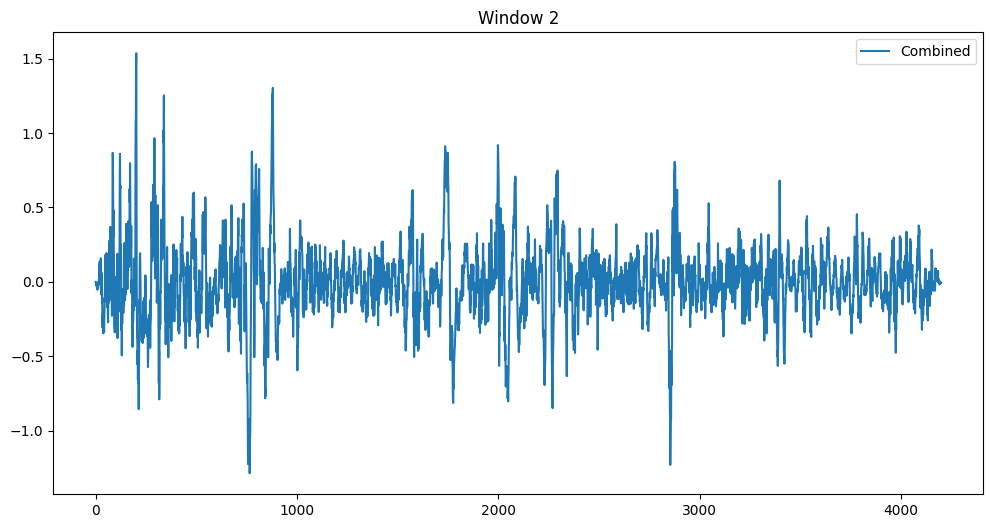

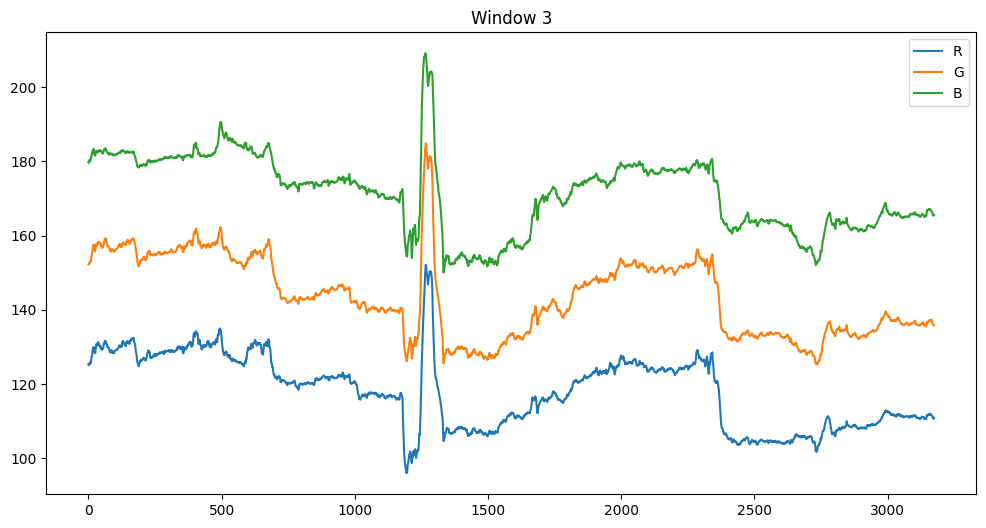

In [45]:
# Display the 4 Moving Window

# Window 0
plt.figure(figsize=(12, 6))
# plt.plot(window_0_r, label='R')
# plt.plot(window_0_g, label='G')
# plt.plot(window_0_b, label='B')
plt.plot(window_0_combined, label='Combined')
plt.title("Window 0")
plt.legend()
plt.show()

# Window 1
plt.figure(figsize=(12, 6))
# plt.plot(window_1_r, label='R')
# plt.plot(window_1_g, label='G')
# plt.plot(window_1_b, label='B')
plt.plot(window_1_combined, label='Combined')
plt.title("Window 1")
plt.legend()
plt.show()

# Window 2
plt.figure(figsize=(12, 6))
# plt.plot(window_2_r, label='R')
# plt.plot(window_2_g, label='G')
# plt.plot(window_2_b, label='B')
plt.plot(window_2_combined, label='Combined')
plt.title("Window 2")
plt.legend()
plt.show()

# Window 3
plt.figure(figsize=(12, 6))
plt.plot(window_3_r, label='R')
plt.plot(window_3_g, label='G')
plt.plot(window_3_b, label='B')
plt.title("Window 3")
plt.legend()
plt.show()


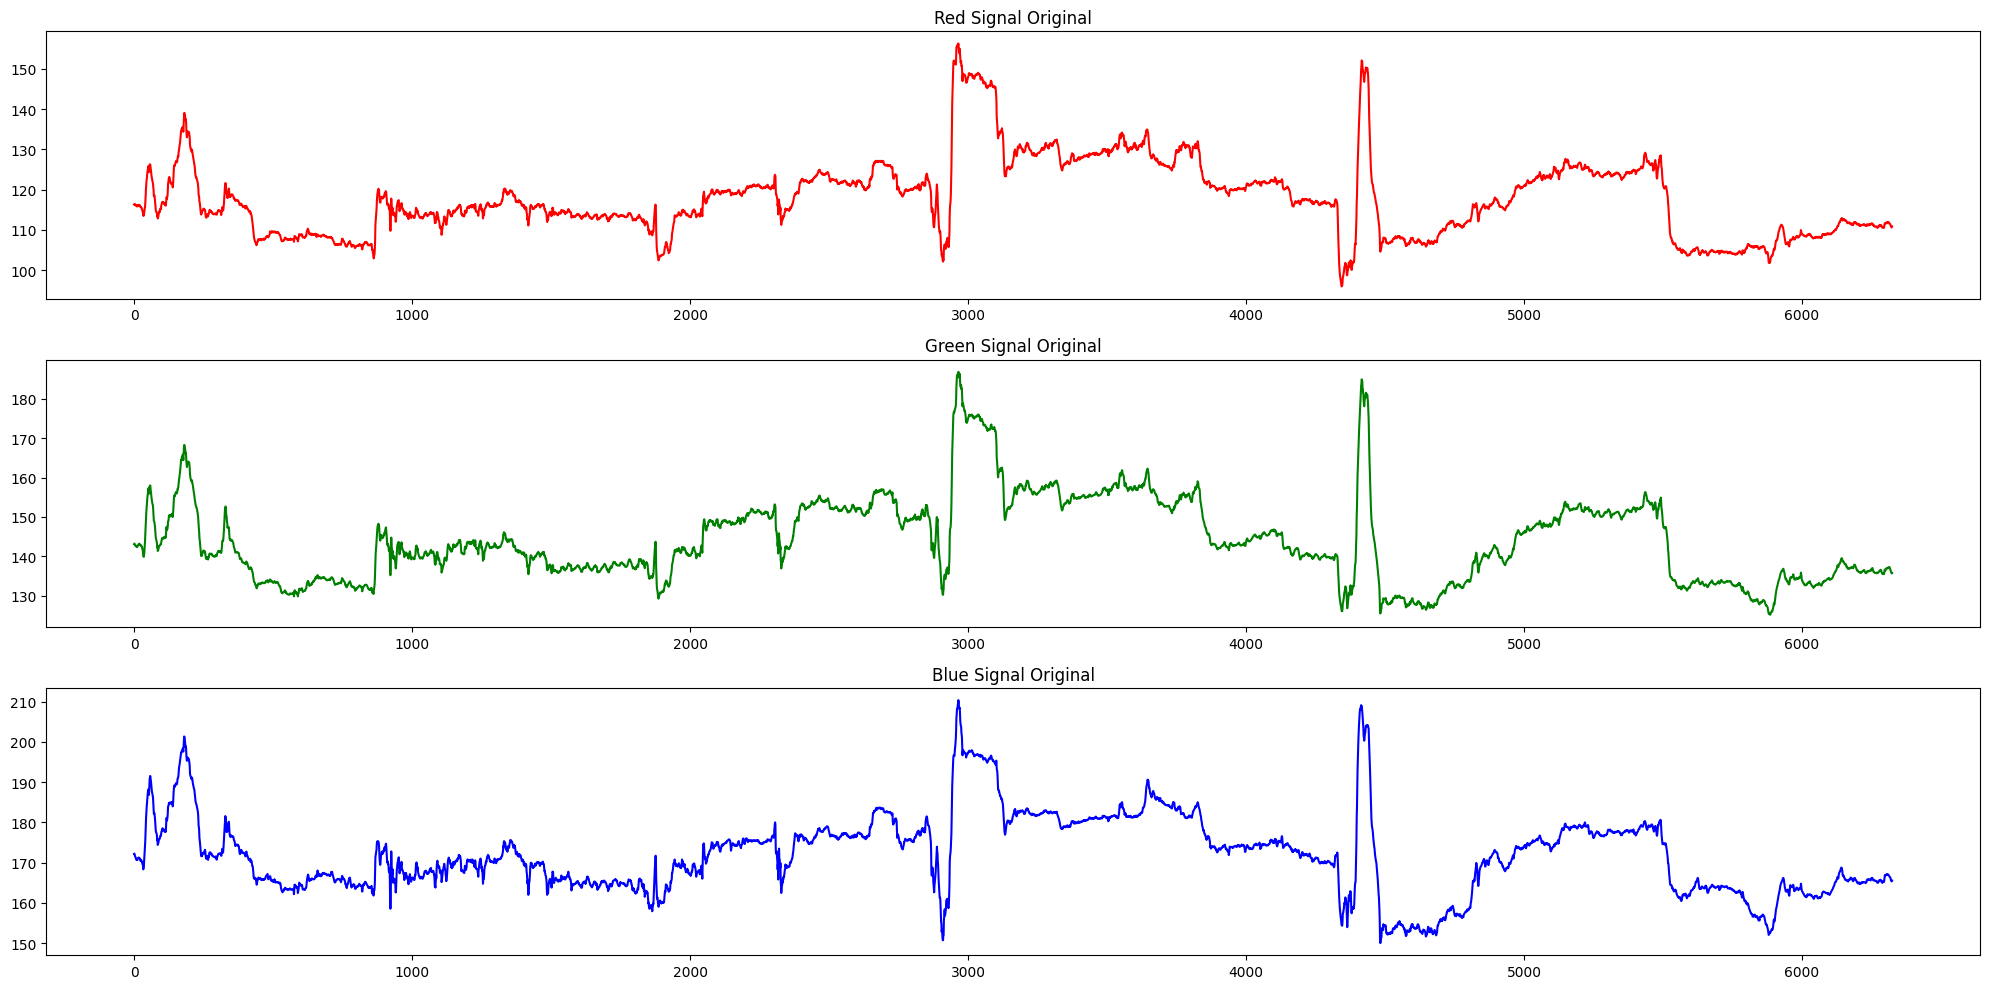

In [46]:
## Show the Signal Graph
ax, fig = plt.subplots(3, 1, figsize=(20, 10))
fig[0].plot(combined_r_signal, color='red')
fig[0].set_title('Red Signal Original')
fig[1].plot(combined_g_signal, color='green')
fig[1].set_title('Green Signal Original')
fig[2].plot(combined_b_signal, color='blue')
fig[2].set_title('Blue Signal Original')
plt.tight_layout()
plt.show()

<hr style="border:20px solid pink; border-radius:5px">

### Pre-Process Signal
Calculate the RPPG process and doing pre-process stuff before doing feature extraction

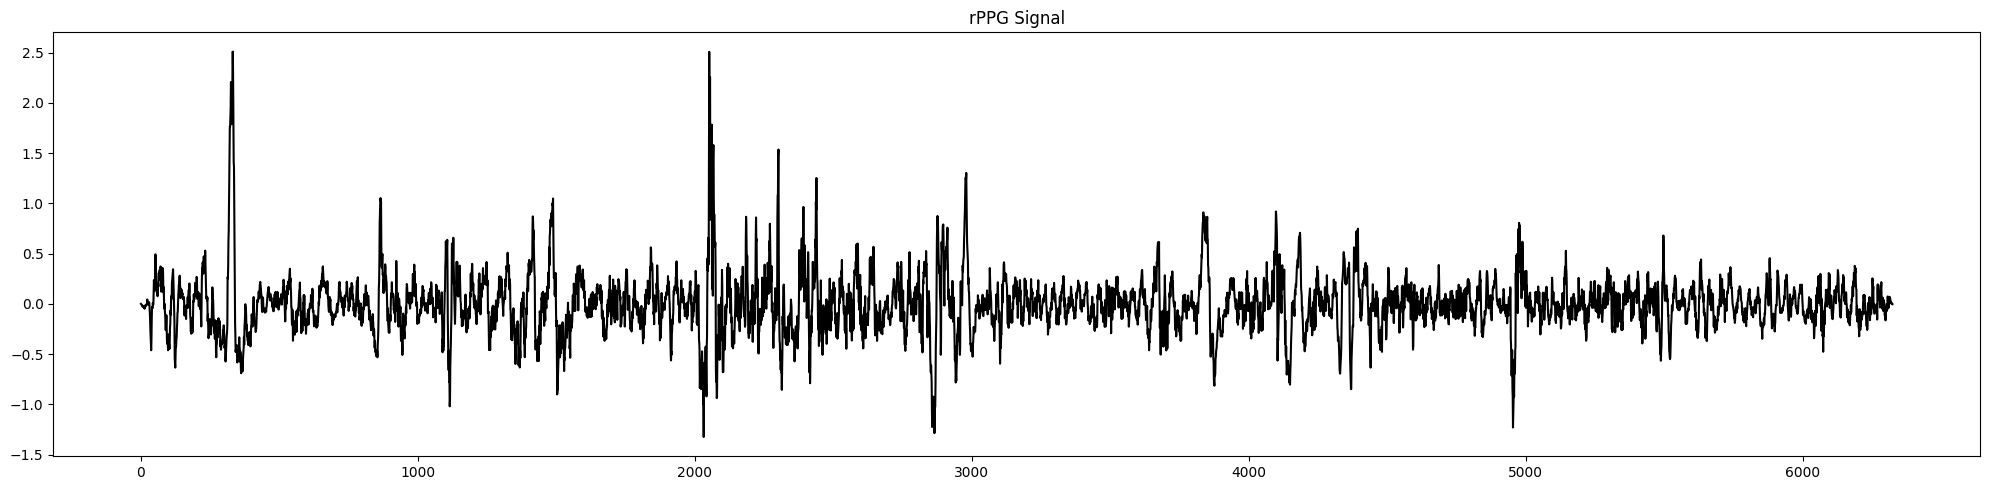

In [47]:
## Calculating the RPPG Signal
rgb_signals = np.array([combined_r_signal, combined_g_signal, combined_b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = POS(rgb_signals, fps=35)
rppg_signal = rppg_signal.reshape(-1)

# Show the RPPG Signal
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

<hr style="border:20px solid red; border-radius:5px">

### Checkpoint
Put the Window RPPG Signal for Further Analysis

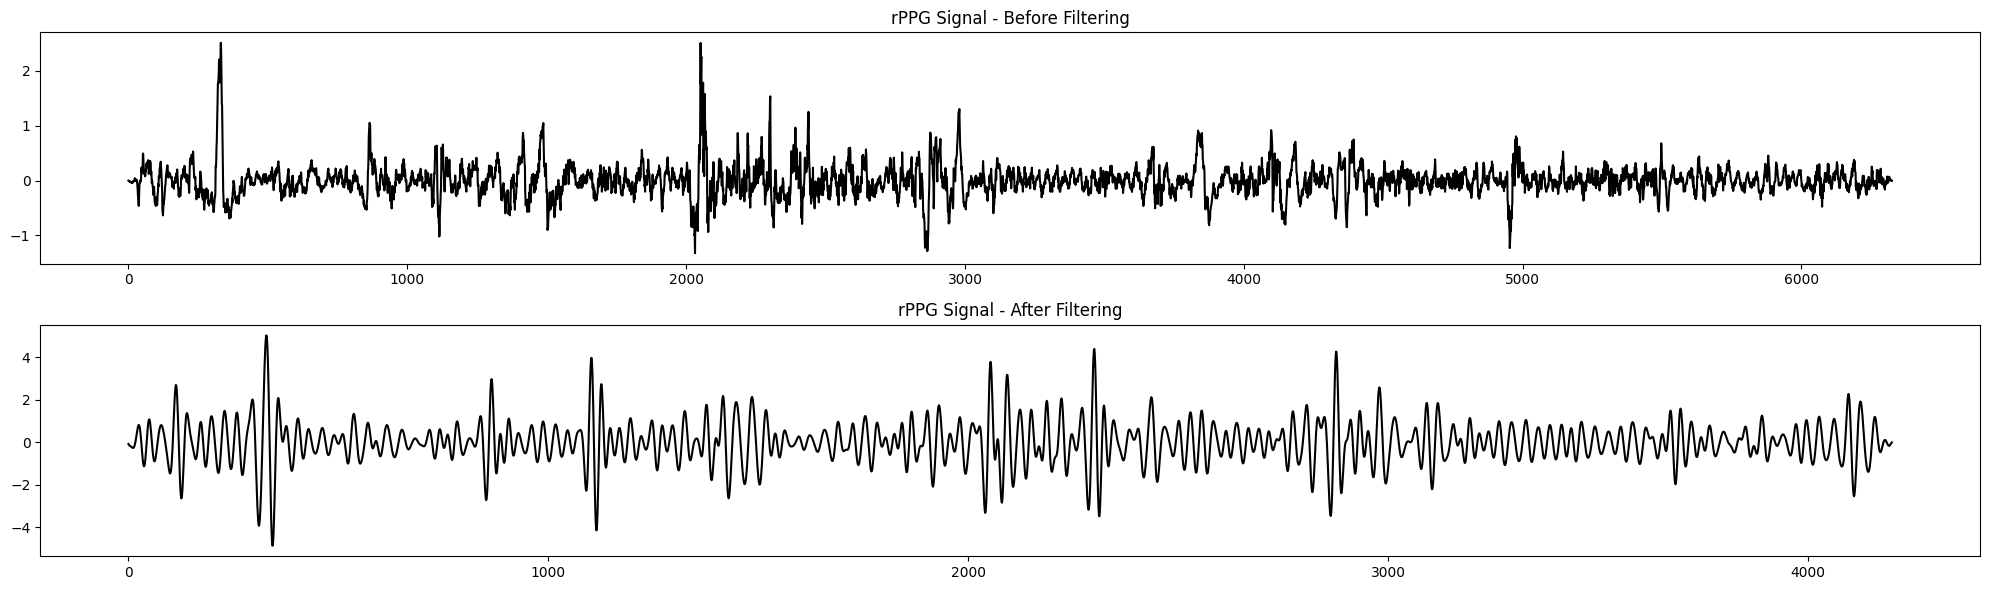

In [48]:
## Filter RPPG Signal
preprocessed_signal = preprocess_ppg(window_0_combined, fs=35)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(preprocessed_signal, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

<hr style="border:20px solid green; border-radius:5px">

### Compare with the Ground truth
Comparing the newly RPPG signal with the ground truth before feature extraction

In [49]:
## Temporal: Slice the Ground Truth data into 2 minute length
gt_signal = downsampled_ground_truth[:len(preprocessed_signal)]
gt_signal = preprocess_ppg(gt_signal, fs=35)

Number of Peaks in rPPG Signal: 135
Number of Peaks in Ground Truth: 131


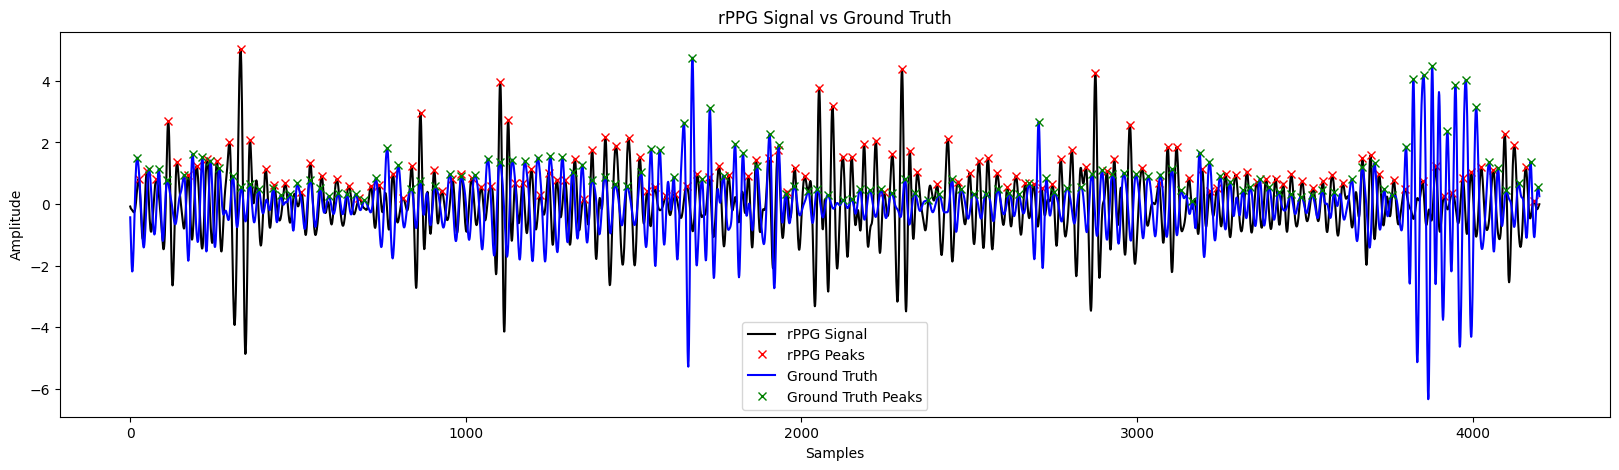

In [50]:
## Finds the Peaks from the Preprocessed Signal and Ground Truth
rppg_peaks, _  = scipy.signal.find_peaks(preprocessed_signal, distance=35 * 0.6, prominence=0.1)
gt_peaks, _ = scipy.signal.find_peaks(gt_signal, distance=35 * 0.6, prominence=0.1)

## Print the Peaks
print(f"Number of Peaks in rPPG Signal: {len(rppg_peaks)}")
print(f"Number of Peaks in Ground Truth: {len(gt_peaks)}")   

## Create the linspace for duration
duration = 120 # 120 seconds
time = np.linspace(0, duration, len(preprocessed_signal))

## Plot the Signal
plt.figure(figsize=(20, 5)) 
plt.plot(preprocessed_signal, color='black', label='rPPG Signal')
plt.plot(rppg_peaks, preprocessed_signal[rppg_peaks], "x", color='red', label='rPPG Peaks')
plt.plot(gt_signal, color='blue', label='Ground Truth')
plt.plot(gt_peaks, gt_signal[gt_peaks], "x", color='green', label='Ground Truth Peaks')
plt.title('rPPG Signal vs Ground Truth')
plt.legend(['rPPG Signal', 'rPPG Peaks', 'Ground Truth', 'Ground Truth Peaks'])
# plt.xlabel('Time (s)')
plt.xlabel("Samples")
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Calculate the Peaks

Since the point in the HRV is the RR-Interval analysis. The key point is to measure the distance-time for each true peak heart beat signal. Let's see in the action.


RPPG Len RR Interval: 116
RPPG Len Cleaned RR Interval: 64


Text(0.5, 0, 'Time (s)')

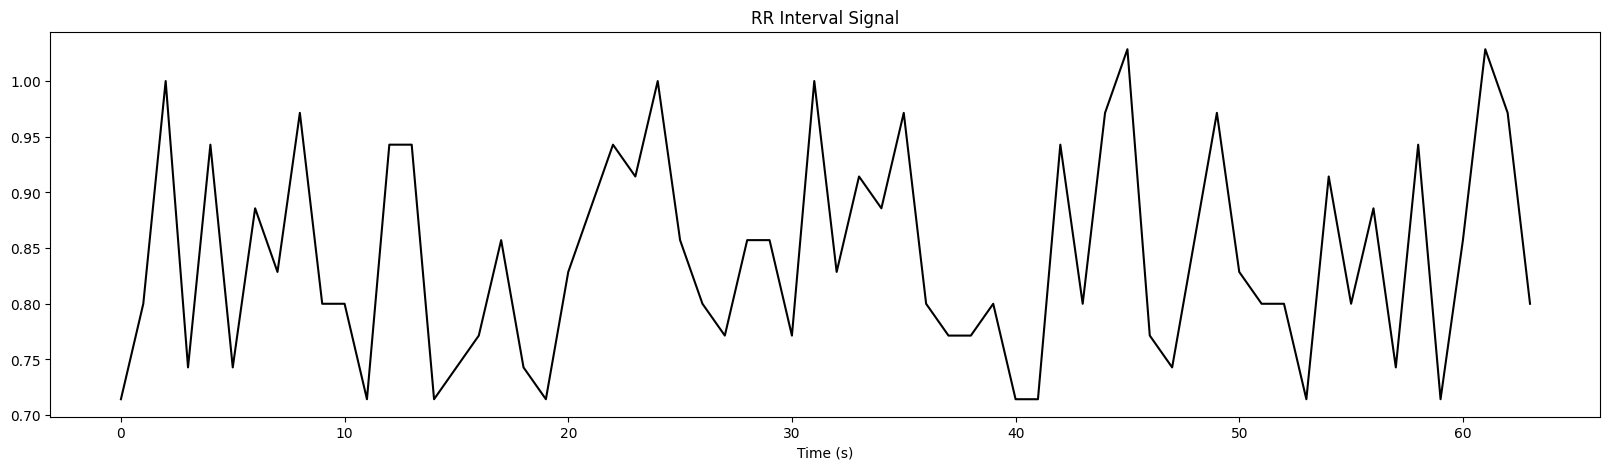

In [51]:
# RPPG Section

## Get RR Interval from the Preprocessed Signal
rppg_rr_interval = get_rr_interval(preprocessed_signal, fs=35)
print("RPPG Len RR Interval:", len(rppg_rr_interval))

# # Clean the RR Interval
# rppg_cleaned_rr_interval = clean_rr_interval(rppg_rr_interval)
# print("RPPG Len Cleaned RR Interval:", len(rppg_rr_interval))

# Clean the RR Interval
rppg_cleaned_rr_interval = clean_rr_adaptive(rppg_rr_interval)
print("RPPG Len Cleaned RR Interval:", len(rppg_cleaned_rr_interval))

## Plot the RR Interval
plt.figure(figsize=(20, 5))
plt.plot(rppg_cleaned_rr_interval, color='black')
plt.title('RR Interval Signal')
plt.xlabel('Time (s)')

GT Len RR Interval: 85
GT Len Cleaned RR Interval: 46


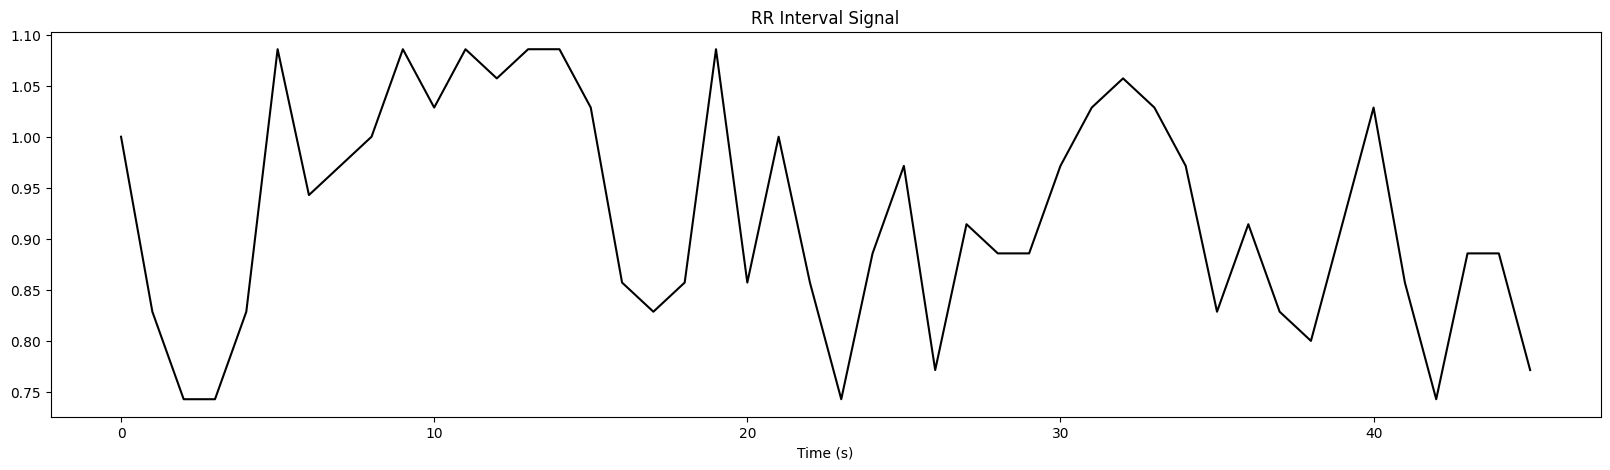

In [52]:
# Ground Truth Section

## Get RR Interval from the Ground Truth
gt_rr_interval = get_rr_interval(gt_signal, fs=35)
print("GT Len RR Interval:", len(gt_rr_interval))

# # ## Clean the RR Interval
# gt_cleaned_rr_interval = clean_rr_interval(gt_rr_interval)
# print("GT Len Cleaned RR Interval:", len(gt_cleaned_rr_interval))

# Clean the RR Interval
gt_cleaned_rr_interval = clean_rr_adaptive(gt_rr_interval)
print("GT Len Cleaned RR Interval:", len(gt_cleaned_rr_interval))

## Plot the RR Interval
plt.figure(figsize=(20, 5))
plt.plot(gt_cleaned_rr_interval, color='black')
plt.title('RR Interval Signal')
plt.xlabel('Time (s)')
plt.show()

<hr style="border:20px solid blue; border-radius:5px">

### Feature Engineering
Let's take the feature out of the RR interval

In [53]:
def extract_time_features(rr_intervals):
    """Extract time-domain features from the RR intervals

    Parameters:
    ----------
    rr_intervals (numpy array): 
        The RR Interval Signal

    Returns:    
    --------
    dict: 
        Dictionary containing the extracted features

    """
    features = { # Convert into seconds
        'mean_rr': np.mean(rr_intervals) * 1000,
        'sdnn': np.std(rr_intervals) * 1000,
        'rmssd': np.sqrt(np.mean(np.diff(rr_intervals)**2)) * 1000,
        'pnn50': (np.diff(rr_intervals) > 0.05).mean() * 100,
        'hr': 60 / np.mean(rr_intervals)
    }
    return features


In [54]:
def frequency_analysis(rr_intervals, fs_interp=4.0):
    """Extract frequency-domain features from the RR intervals

    Parameters:
    ----------
    rr_intervals (numpy array): 
        The RR Interval Signal
    fs_interp (float):
        The Interpolated Sampling Frequency

    Returns:
    --------
    dict: 
        Dictionary containing the extracted features

    """
    # Interpolate to uniform sampling
    time_points = np.cumsum(rr_intervals)
    f_interp = scipy.interpolate.interp1d(time_points, rr_intervals, kind='cubic')
    
    # Create uniform time axis
    t_uniform = np.arange(time_points[0], time_points[-1], 1/fs_interp)
    rr_uniform = f_interp(t_uniform)
    
    # Welch's method
    frequencies, psd = scipy.signal.welch(rr_uniform, fs=fs_interp, nperseg=256)
    
    # Calculate frequency bands
    vlf = np.trapz(psd[(frequencies >= 0.0033) & (frequencies < 0.04)])
    lf = np.trapz(psd[(frequencies >= 0.04) & (frequencies < 0.15)])
    hf = np.trapz(psd[(frequencies >= 0.15) & (frequencies < 0.4)])

    ## Plot the PSD in more detail for each frequency band
    plt.figure(figsize=(20, 5))
    plt.plot(frequencies, psd)
    plt.fill_between(frequencies, psd, where=(frequencies >= 0.0033) & (frequencies < 0.04), color='red', alpha=0.5)
    plt.fill_between(frequencies, psd, where=(frequencies >= 0.04) & (frequencies < 0.15), color='green', alpha=0.5)
    plt.fill_between(frequencies, psd, where=(frequencies >= 0.15) & (frequencies < 0.4), color='blue', alpha=0.5)
    plt.title("Power Spectral Density")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.show()
    
    
    return {'vlf': vlf, 'lf': lf, 'hf': hf, 'lf_hf_ratio': lf/hf}

### RPPG Signal Feature Extraction
RPPG Signal section Feature Extraction

Time Features:  {'mean_rr': 842.4107142857142, 'sdnn': 92.99333247714095, 'rmssd': 131.3259976344399, 'pnn50': 39.682539682539684, 'hr': 71.22416534181241}


c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 213, using nperseg = 213
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


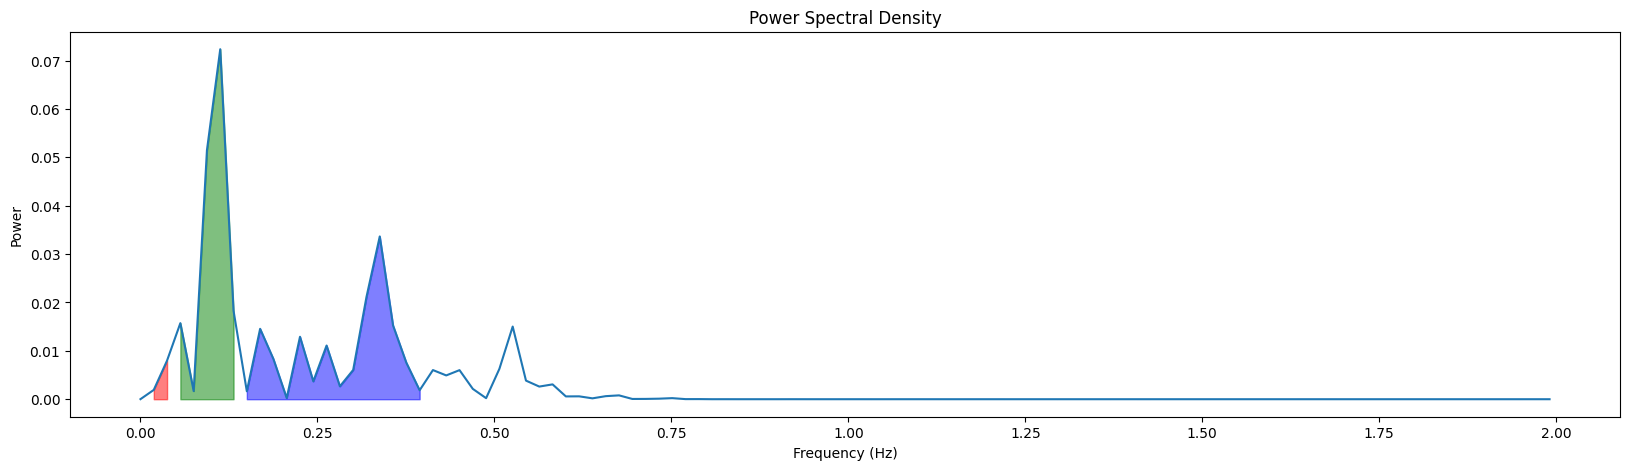

Frequency Features:  {'vlf': 0.004960526837820146, 'lf': 0.14252181833681898, 'hf': 0.13883447396404724, 'lf_hf_ratio': 1.0265592850787666}


In [55]:
## Get the Time Features
time_features = extract_time_features(rppg_cleaned_rr_interval) 
print("Time Features: ", time_features)

## Get the Frequency Features
frequency_features = frequency_analysis(rppg_cleaned_rr_interval)
print("Frequency Features: ", frequency_features)


### GT Signal Feature Extraction
GT Signal section Feature Extraction

Time Features:  {'mean_rr': 924.2236024844719, 'sdnn': 108.58734621863448, 'rmssd': 113.8085275907783, 'pnn50': 33.33333333333333, 'hr': 64.9193548387097}


c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 167, using nperseg = 167
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


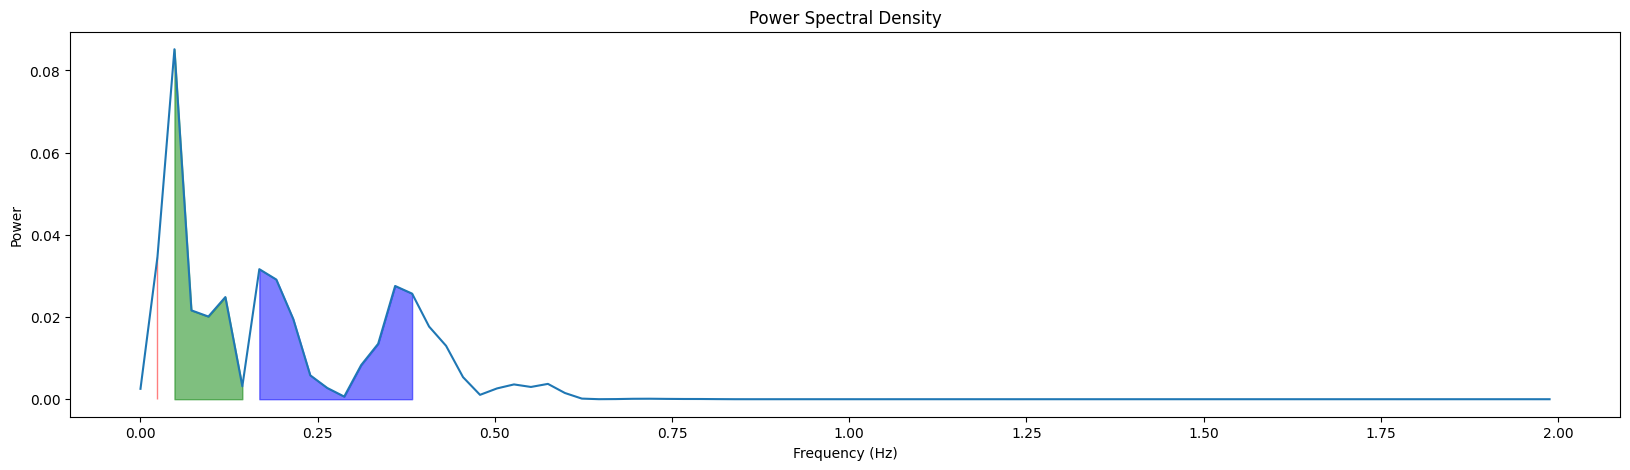

Frequency Features:  {'vlf': 0.0, 'lf': 0.11075857811595954, 'hf': 0.13587727059488175, 'lf_hf_ratio': 0.8151369072328983}


In [56]:
## Get the Time Features
time_features = extract_time_features(gt_cleaned_rr_interval) 
print("Time Features: ", time_features)

## Get the Frequency Features
frequency_features = frequency_analysis(gt_cleaned_rr_interval)
print("Frequency Features: ", frequency_features)


<hr style="border:20px solid magenta; border-radius:5px">

## Emotion Analysis - Based HRV
Let's go

In [57]:
## Claude One

from scipy.interpolate import interp1d

def extract_hrv_features(rppg_signal, sampling_rate=35):
    """
    Extract HRV features from filtered rPPG signal in both time and frequency domains.
    
    Parameters:
    -----------
    rppg_signal : array-like
        The filtered rPPG signal
    sampling_rate : int
        Sampling rate of the signal in Hz (default: 35)
        
    Returns:
    --------
    dict
        Dictionary containing HRV features
    """
    # Find peaks (R-peaks equivalent in rPPG)
    peaks, _ = scipy.signal.find_peaks(rppg_signal, distance=sampling_rate//2)
    print("Total Peaks: ", len(peaks))
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(peaks) * (1000 / sampling_rate)
    
    # Remove outliers (basic cleaning)
    rr_cleaned = remove_outliers(rr_intervals)
    
    # Time domain features
    time_features = calculate_time_domain_features(rr_cleaned)
    print("Time: ", time_features)
    
    # Frequency domain features
    freq_features = calculate_frequency_domain_features(rr_cleaned, sampling_rate)
    print("Freq: ", freq_features)
    
    # Combine all features
    features = {**time_features, **freq_features}
    
    return features

def remove_outliers(rr_intervals, threshold=2.0):
    """
    Remove outliers from RR intervals using z-score method
    """
    z_scores = np.abs(scipy.signal.detrend(rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals))
    return rr_intervals[z_scores < threshold]

def calculate_time_domain_features(rr_intervals):
    """
    Calculate time domain HRV features
    """
    features = {}
    
    # Mean RR interval (AVNN)
    features['mean_rr'] = np.mean(rr_intervals)
    
    # Standard deviation of RR intervals (SDNN)
    features['sdnn'] = np.std(rr_intervals)
    
    # Root mean square of successive differences (RMSSD)
    rr_diff = np.diff(rr_intervals)
    features['rmssd'] = np.sqrt(np.mean(rr_diff ** 2))
    
    # Percentage of successive RR intervals differing by more than 50ms (pNN50)
    nn50 = sum(abs(rr_diff) > 50)
    features['pnn50'] = (nn50 / len(rr_diff)) * 100
    
    return features

def calculate_frequency_domain_features(rr_intervals, sampling_rate):
    """
    Calculate frequency domain HRV features
    """
    features = {}
    
    # Interpolate RR intervals to get evenly sampled signal
    time_points = np.cumsum(rr_intervals) / 1000  # Convert to seconds
    f = interp1d(time_points, rr_intervals, kind='cubic')
    
    # Create evenly sampled time points
    even_time_points = np.linspace(time_points[0], time_points[-1], len(rr_intervals))
    interpolated_rr = f(even_time_points)
    
    # Calculate power spectral density using Welch's method
    frequencies, psd = scipy.signal.welch(interpolated_rr, 
                                  fs=sampling_rate,
                                  nperseg=len(interpolated_rr)//2)
    
    # Define frequency bands
    vlf_mask = (frequencies >= 0.0033) & (frequencies < 0.04)  # Very low frequency
    lf_mask = (frequencies >= 0.04) & (frequencies < 0.15)    # Low frequency
    hf_mask = (frequencies >= 0.15) & (frequencies < 0.4)     # High frequency
    
    # Calculate power in each band
    features['vlf_power'] = np.trapz(psd[vlf_mask], frequencies[vlf_mask])
    features['lf_power'] = np.trapz(psd[lf_mask], frequencies[lf_mask])
    features['hf_power'] = np.trapz(psd[hf_mask], frequencies[hf_mask])
    
    # Calculate LF/HF ratio
    features['lf_hf_ratio'] = features['lf_power'] / features['hf_power']
    
    # Calculate total power
    features['total_power'] = features['vlf_power'] + features['lf_power'] + features['hf_power']
    
    # Calculate normalized powers
    features['lf_power_norm'] = features['lf_power'] / (features['lf_power'] + features['hf_power']) * 100
    features['hf_power_norm'] = features['hf_power'] / (features['lf_power'] + features['hf_power']) * 100
    
    return features

# Extract features
features = extract_hrv_features(downsampled_ground_truth, sampling_rate=35)

# Print results
for feature, value in features.items():
    print(f"{feature}: {value:.2f}")


Total Peaks:  219
Time:  {'mean_rr': 808.5848423876593, 'sdnn': 183.23705036281558, 'rmssd': 224.33747063656887, 'pnn50': 83.9622641509434}
Freq:  {'vlf_power': 0.0, 'lf_power': 0.0, 'hf_power': 0.0, 'lf_hf_ratio': nan, 'total_power': 0.0, 'lf_power_norm': nan, 'hf_power_norm': nan}
mean_rr: 808.58
sdnn: 183.24
rmssd: 224.34
pnn50: 83.96
vlf_power: 0.00
lf_power: 0.00
hf_power: 0.00
lf_hf_ratio: nan
total_power: 0.00
lf_power_norm: nan
hf_power_norm: nan


C:\Users\ACER\AppData\Local\Temp\ipykernel_7676\2519045406.py:103: RuntimeWarning: invalid value encountered in scalar divide
  features['lf_hf_ratio'] = features['lf_power'] / features['hf_power']
C:\Users\ACER\AppData\Local\Temp\ipykernel_7676\2519045406.py:109: RuntimeWarning: invalid value encountered in scalar divide
  features['lf_power_norm'] = features['lf_power'] / (features['lf_power'] + features['hf_power']) * 100
C:\Users\ACER\AppData\Local\Temp\ipykernel_7676\2519045406.py:110: RuntimeWarning: invalid value encountered in scalar divide
  features['hf_power_norm'] = features['hf_power'] / (features['lf_power'] + features['hf_power']) * 100


----

### Stress Detector Class
Based on the RR, we can map the Stress, but the question itself, how do we can obtain real and clean RR?

In [58]:
# import numpy as np

# class StressDetector:
#     """
#     A rule-based stress detection system using HRV features.
    
#     This class implements stress detection using both time and frequency domain HRV features.
#     The rules are based on established physiological thresholds from HRV research literature.
#     Stress is typically associated with:
#     - Decreased SDNN (reduced overall variability)
#     - Decreased RMSSD (reduced short-term variability)
#     - Decreased pNN50 (reduced parasympathetic activity)
#     - Increased LF/HF ratio (sympathetic dominance)
#     - Decreased HF power (reduced parasympathetic activity)
#     """
    
#     def __init__(self):
#         # Define thresholds for various HRV parameters
#         # These thresholds are based on literature values for normal vs stressed states
#         self.thresholds = {
#             'sdnn': {
#                 'low_stress': 50,    # ms: Higher values indicate relaxed state
#                 'high_stress': 30    # ms: Lower values indicate stress
#             },
#             'rmssd': {
#                 'low_stress': 30,    # ms: Higher values indicate relaxed state
#                 'high_stress': 20    # ms: Lower values indicate stress
#             },
#             'pnn50': {
#                 'low_stress': 40,    # %: Higher values indicate relaxed state
#                 'high_stress': 20    # %: Lower values indicate stress
#             },
#             'lf_hf_ratio': {
#                 'low_stress': 2.0,   # Lower values indicate relaxed state
#                 'high_stress': 3.0   # Higher values indicate stress
#             },
#             'hf_power_nu': {
#                 'low_stress': 40,    # n.u.: Higher values indicate relaxed state
#                 'high_stress': 20    # n.u.: Lower values indicate stress
#             }
#         }
    
#     def detect_stress(self, features):
#         """
#         Detect stress levels based on HRV features.
        
#         Parameters:
#         -----------
#         features : dict
#             Dictionary containing HRV features from time and frequency domains
            
#         Returns:
#         --------
#         dict
#             Dictionary containing stress assessment results
#         """
#         # Initialize stress scores for different parameters
#         stress_scores = {}
        
#         # Evaluate SDNN (Standard deviation of NN intervals)
#         stress_scores['sdnn'] = self._evaluate_parameter(
#             features['sdnn'],
#             self.thresholds['sdnn']['high_stress'],
#             self.thresholds['sdnn']['low_stress'],
#             inverse=True
#         )
        
#         # Evaluate RMSSD (Root mean square of successive differences)
#         stress_scores['rmssd'] = self._evaluate_parameter(
#             features['rmssd'],
#             self.thresholds['rmssd']['high_stress'],
#             self.thresholds['rmssd']['low_stress'],
#             inverse=True
#         )
        
#         # Evaluate pNN50 (Percentage of successive NN intervals differing by > 50ms)
#         stress_scores['pnn50'] = self._evaluate_parameter(
#             features['pnn50'],
#             self.thresholds['pnn50']['high_stress'],
#             self.thresholds['pnn50']['low_stress'],
#             inverse=True
#         )
        
#         # Evaluate LF/HF ratio
#         stress_scores['lf_hf_ratio'] = self._evaluate_parameter(
#             features['lf_hf_ratio'],
#             self.thresholds['lf_hf_ratio']['low_stress'],
#             self.thresholds['lf_hf_ratio']['high_stress'],
#             inverse=True
#         )
        
#         # Evaluate normalized HF power
#         stress_scores['hf_power'] = self._evaluate_parameter(
#             features['hf_power_nu'],
#             self.thresholds['hf_power_nu']['high_stress'],
#             self.thresholds['hf_power_nu']['low_stress'],
#             inverse=True
#         )
        
#         # Calculate overall stress score (weighted average)
#         weights = {
#             'sdnn': 0.2,
#             'rmssd': 0.2,
#             'pnn50': 0.2,
#             'lf_hf_ratio': 0.2,
#             'hf_power': 0.2
#         }
        
#         overall_score = sum(stress_scores[param] * weights[param] 
#                           for param in stress_scores.keys())
        
#         # Determine stress level category
#         stress_level = self._categorize_stress(overall_score)
        
#         # Prepare detailed analysis
#         analysis = {
#             'overall_stress_score': overall_score,
#             'stress_level': stress_level,
#             'parameter_scores': stress_scores,
#             'interpretation': self._generate_interpretation(stress_scores, overall_score)
#         }
        
#         return analysis
    
#     def _evaluate_parameter(self, value, high_stress_threshold, low_stress_threshold, inverse=False):
#         """
#         Evaluate a single parameter and return a stress score between 0 and 1.
#         0 indicates no stress, 1 indicates high stress.
        
#         The 'inverse' parameter handles cases where higher values indicate less stress
#         (like SDNN, RMSSD) vs cases where higher values indicate more stress (like LF/HF ratio).
#         """
#         if inverse:
#             # For parameters where higher values indicate less stress
#             if value >= low_stress_threshold:
#                 return 0.0
#             elif value <= high_stress_threshold:
#                 return 1.0
#             else:
#                 # Linear interpolation between thresholds
#                 return (low_stress_threshold - value) / (low_stress_threshold - high_stress_threshold)
#         else:
#             # For parameters where higher values indicate more stress
#             if value <= low_stress_threshold:
#                 return 0.0
#             elif value >= high_stress_threshold:
#                 return 1.0
#             else:
#                 # Linear interpolation between thresholds
#                 return (value - low_stress_threshold) / (high_stress_threshold - low_stress_threshold)
    
#     def _categorize_stress(self, score):
#         """
#         Categorize the stress level based on the overall score.
#         """
#         if score < 0.3:
#             return "Low stress - Relaxed state"
#         elif score < 0.6:
#             return "Moderate stress"
#         else:
#             return "High stress"
    
#     def _generate_interpretation(self, scores, overall_score):
#         """
#         Generate a detailed interpretation of the stress analysis.
#         """
#         interpretations = []
        
#         # Add overall stress level interpretation
#         interpretations.append(f"Overall stress level: {self._categorize_stress(overall_score)}")
#         interpretations.append(f"Overall stress score: {overall_score:.2f} (0-1 scale)")
        
#         # Add specific parameter interpretations
#         param_names = {
#             'sdnn': 'Overall heart rate variability (SDNN)',
#             'rmssd': 'Short-term variability (RMSSD)',
#             'pnn50': 'Beat-to-beat variability (pNN50)',
#             'lf_hf_ratio': 'Autonomic balance (LF/HF ratio)',
#             'hf_power': 'Parasympathetic activity (HF power)'
#         }
        
#         for param, score in scores.items():
#             status = "high" if score > 0.6 else "moderate" if score > 0.3 else "low"
#             interpretations.append(f"{param_names[param]}: {status} stress indication (score: {score:.2f})")
        
#         return "\n".join(interpretations)

# # Example usage
# if __name__ == "__main__":
#     # Create sample HRV features
#     sample_features = {
#         'sdnn': 45,
#         'rmssd': 25,
#         'pnn50': 30,
#         'lf_hf_ratio': 2.5,
#         'hf_power_nu': 30
#     }
    
#     # Create stress detector and analyze
#     detector = StressDetector()
#     print(features)
#     stress_analysis = detector.detect_stress(features)
    
#     # Print results
#     print("\nStress Analysis Results:")
#     print("------------------------")
#     print(stress_analysis['interpretation'])